In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
from matplotlib import pyplot as plt

from counterfactuals.datasets import MNISTDataset
from counterfactuals.losses import BinaryDiscLoss
from counterfactuals.cf_methods.group_ppcef.rppcef import RPPCEF
from counterfactuals.generative_models import MaskedAutoregressiveFlow
from counterfactuals.discriminative_models import (
    LogisticRegression,
    MultilayerPerceptron,
)
from counterfactuals.metrics import CFMetrics

/Users/ofurman/Private/counterfactuals/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# dataset = MnistDataset("../data/mnist.csv")
# dataset = LawDataset("../data/law.csv")
# dataset = HelocDataset("../data/heloc.csv")
dataset = MNISTDataset("../data/mnist.csv")

In [11]:
disc_model = MultilayerPerceptron(dataset.X_test.shape[1], [512, 512], 1)
disc_model.fit(
    dataset.train_dataloader(batch_size=128, shuffle=True),
    dataset.test_dataloader(batch_size=128, shuffle=False),
    epochs=5000,
    patience=100,
    lr=1e-3,
    checkpoint_path="mnist_disc_model.pt",
)
# disc_model.load("disc_model.pt")

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/ofurman/Private/counterfactuals/counterfactuals/discriminative_models/multilayer_perceptron.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this expe

In [114]:
disc_model = LogisticRegression(dataset.X_test.shape[1], 1)
disc_model.fit(
    dataset.train_dataloader(batch_size=256, shuffle=True),
    dataset.test_dataloader(batch_size=256, shuffle=False),
    epochs=5000,
    patience=100,
    checkpoint_path="disc_model.pt",
)
# disc_model.load("disc_model.pt")

Epoch 2654, Train: 0.0822, test: 0.0885, patience: 100:  53%|█████▎    | 2654/5000 [00:06<00:06, 381.66it/s]
/Users/ofurman/Private/counterfactuals/counterfactuals/discriminative_models/logistic_regression.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. 

In [12]:
y_pred = disc_model.predict(dataset.X_test).detach().numpy().flatten()
print("Test accuracy:", (y_pred == dataset.y_test).mean())

Test accuracy: 0.99


In [127]:
dataset.y_train = disc_model.predict(dataset.X_train).detach().numpy()
dataset.y_test = disc_model.predict(dataset.X_test).detach().numpy()

In [5]:
# dataset = MoonsDataset("../data/moons.csv")
# dataset = MnistDataset("../data/mnist.csv")
# train_dataloader = dataset.train_dataloader(batch_size=1024, shuffle=True)
# test_dataloader = dataset.test_dataloader(batch_size=1024, shuffle=False)

# disc_model = LogisticRegression(dataset.X_test.shape[1], 1)
# disc_model.fit(
#     dataset.train_dataloader(batch_size=1024, shuffle=True),
#     dataset.test_dataloader(batch_size=1024, shuffle=False),
#     epochs=1000
# )

gen_model = MaskedAutoregressiveFlow(
    features=dataset.X_train.shape[1],
    hidden_features=512,
    num_blocks_per_layer=2,
    num_layers=5,
    context_features=1,
    batch_norm_within_layers=False,
    batch_norm_between_layers=False,
    use_random_permutations=False,
)
train_dataloader = dataset.train_dataloader(batch_size=256, shuffle=True, noise_lvl=0.0)
test_dataloader = dataset.test_dataloader(batch_size=256, shuffle=False)

gen_model.fit(
    train_dataloader,
    test_dataloader,
    learning_rate=1e-5,
    patience=30,
    num_epochs=300,
    checkpoint_path="flow.pth",
)
# gen_model.load("flow.pth")

Epoch 299, Train: -388.3045, test: -350.3311, patience: 0: 100%|██████████| 300/300 [01:01<00:00,  4.88it/s]
/Users/ofurman/Private/counterfactuals/counterfactuals/generative_models/maf/maf.py:154: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an 

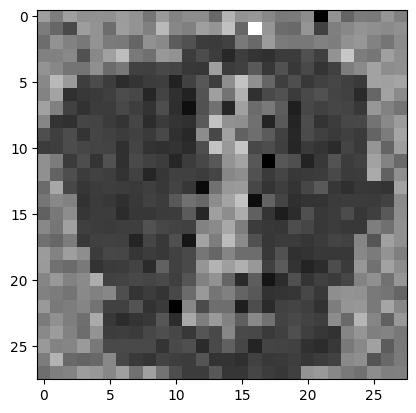

In [10]:
with torch.no_grad():
    plt.imshow(
        gen_model.sample_and_log_prob(1, context=torch.tensor([0.0]))[0]
        .view(28, 28)
        .detach()
        .numpy(),
        cmap="gray",
    )

In [130]:
# plt.imshow(dataset.X_train[6].reshape(28, 28), cmap="gray")

In [13]:
source_class = 1
target_class = 0
X_test_origin = dataset.X_test[dataset.y_test == source_class]
y_test_origin = dataset.y_test[dataset.y_test == source_class]

In [15]:
cf_method = RPPCEF(
    X=X_test_origin,
    cf_method_type="GCE",
    K=6,
    gen_model=gen_model,
    disc_model=disc_model,
    disc_model_criterion=BinaryDiscLoss(),
    actionable_features=None,
    neptune_run=None,
)

In [16]:
train_dataloader_for_log_prob = dataset.train_dataloader(batch_size=4096, shuffle=False)
log_prob_threshold = torch.quantile(
    gen_model.predict_log_prob(train_dataloader_for_log_prob),
    0.25,
)

cf_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_test_origin).float(),
        torch.tensor(y_test_origin).float(),
    ),
    batch_size=4096,
    shuffle=False,
)


delta, Xs, ys_orig, ys_target = cf_method.explain_dataloader(
    dataloader=cf_dataloader,
    epochs=20000,
    lr=0.003,
    patience=1000,
    alpha=100,
    alpha_s=100,
    alpha_k=100,
    log_prob_threshold=log_prob_threshold,
)

loss: 6770.0864, dist: 118.8743, max_inner: 67.1134, loss_disc: 0.0000, delta_loss: 46.8623:  25%|██▌       | 5062/20000 [01:17<03:49, 64.98it/s] 


In [17]:
M, S, D = delta.get_matrices()

In [18]:
S.sum(axis=0)

tensor([ 9.6635,  6.0887,  2.9797,  0.9565,  7.3405, 19.9711],
       grad_fn=<SumBackward1>)

In [20]:
values, indexes = S.max(dim=1)

total = len(values)
i_correct = indexes[values == 1]
print(f"Correct: {len(i_correct)}/{total}")
print(len(set(i_correct.tolist())))

Correct: 12/47
3


In [21]:
Xs_cfs = Xs + delta().detach().numpy()

In [22]:
y_pred = disc_model.predict(Xs_cfs).detach().numpy().flatten()
print("Test accuracy:", (y_pred == ys_target).mean())

Test accuracy: 1.0


In [23]:
metrics = CFMetrics(
    X_cf=Xs_cfs,
    y_target=ys_target,
    X_train=dataset.X_train,
    y_train=dataset.y_train,
    X_test=X_test_origin,
    y_test=y_test_origin,
    disc_model=disc_model,
    gen_model=gen_model,
    continuous_features=list(range(dataset.X_train.shape[1])),
    categorical_features=dataset.categorical_features,
    prob_plausibility_threshold=log_prob_threshold,
)

In [24]:
metrics.calc_all_metrics()

{'coverage': 1.0,
 'validity': 1.0,
 'actionability': 0.0,
 'sparsity': 1.0,
 'proximity_categorical_hamming': nan,
 'proximity_categorical_jaccard': 6.344363095980586,
 'proximity_continuous_manhattan': 118.88410606678697,
 'proximity_continuous_euclidean': 6.344363095980586,
 'proximity_continuous_mad': 2868.9326169335723,
 'proximity_l2_jaccard': 6.344363095980586,
 'proximity_mad_hamming': nan,
 'prob_plausibility': 0.3617021276595745,
 'log_density_cf': 199.57782,
 'log_density_test': -1306.4183,
 'lof_scores_cf': 1.3974196,
 'lof_scores_test': 1.0699571,
 'isolation_forest_scores_cf': 0.016398195894221278,
 'isolation_forest_scores_test': 0.057410830099289115}

# TODO
1. Wziąć duo więcej próbek
2. Bez grupowych spróbować
3. Grupowe bez triku
3. Poprawić dekwantyzacje (nie powinno tak być)
4. Przeanalizować ręcznie LOF oraz IsoForest (czy działa na obrazkach)
4.5 IsoForest - zrobić głębokie drzewa

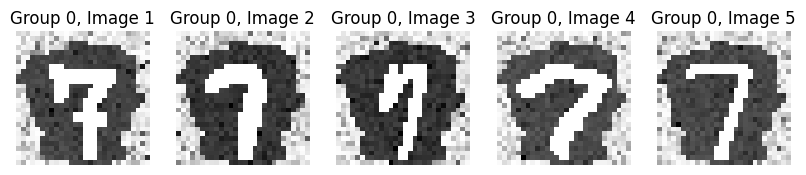

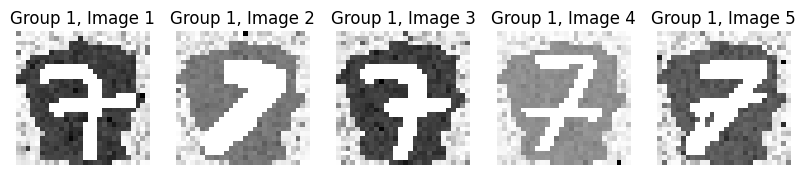

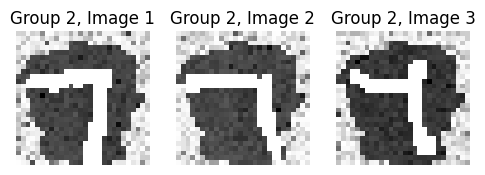

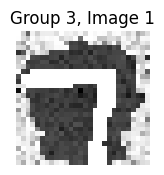

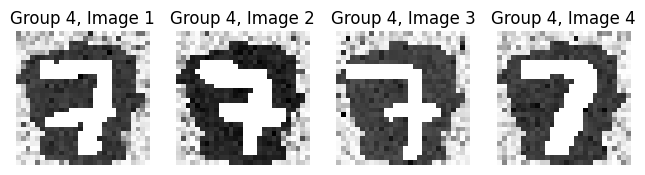

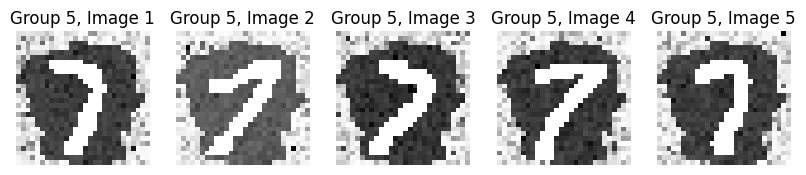

In [40]:
unique_groups = torch.unique(S.argmax(dim=1))

for group in unique_groups:
    group_indices = np.where(S.argmax(dim=1).numpy() == group.item())[0]
    num_images = min(5, len(group_indices))
    selected_indices = group_indices[:num_images]

    plt.figure(figsize=(10, 2 * num_images))
    for i, idx in enumerate(selected_indices):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X_test_origin[idx].reshape(28, 28), cmap="gray")
        plt.title(f"Group {group.item()}, Image {i + 1}")
        plt.axis("off")
    plt.show()

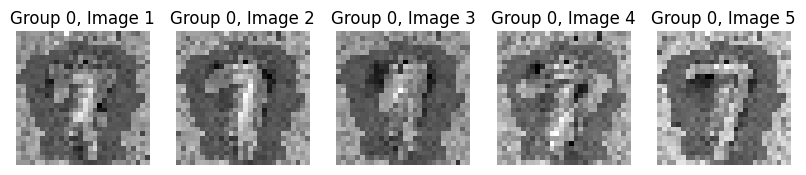

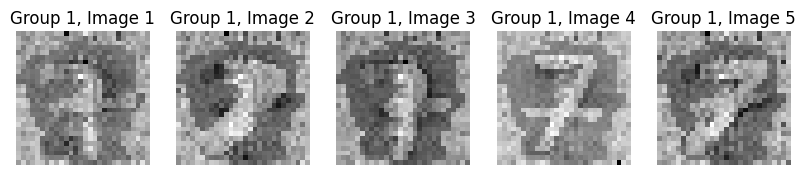

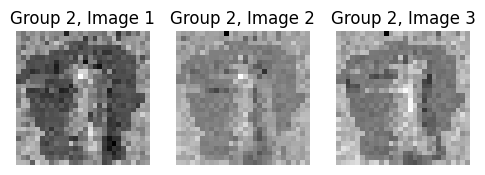

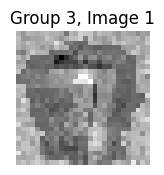

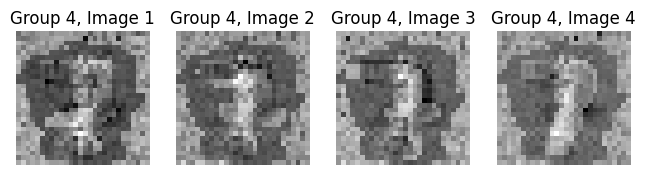

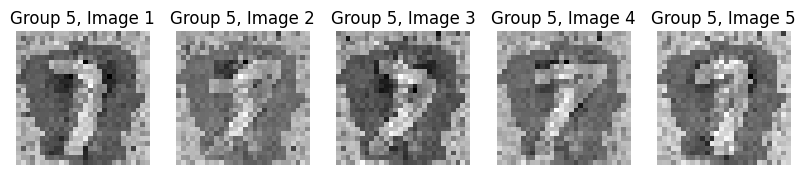

In [41]:
unique_groups = torch.unique(S.argmax(dim=1))

for group in unique_groups:
    group_indices = np.where(S.argmax(dim=1).numpy() == group.item())[0]
    num_images = min(5, len(group_indices))
    selected_indices = group_indices[:num_images]

    plt.figure(figsize=(10, 2 * num_images))
    for i, idx in enumerate(selected_indices):
        plt.subplot(1, 5, i + 1)
        plt.imshow(Xs_cfs[idx].reshape(28, 28), cmap="gray")
        plt.title(f"Group {group.item()}, Image {i + 1}")
        plt.axis("off")
    plt.show()